In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Part 1: Setting up the data ##

In [2]:
# Load the 2024 weather data
weather_2024 = Table().read_table('merced_weather_2024_september.csv')
weather_2024 = weather_2024.select(['Date', 'Maximum Temperature', 'Minimum Temperature'])
weather_2024

#weather_2024.hist('Maximum Temperature')

Date,Maximum Temperature,Minimum Temperature
2024-09-01,97,64
2024-09-02,94,62
2024-09-03,98,57
2024-09-04,103,62
2024-09-05,104,69
2024-09-06,105,67
2024-09-07,105,66
2024-09-08,105,68
2024-09-09,106,63
2024-09-10,91,61


In [3]:
# Load the 2004 weather data
weather_2004 = Table().read_table('merced_weather_2004_september.csv')
weather_2004 = weather_2004.select(['Date', 'Maximum Temperature', 'Minimum Temperature'])
weather_2004


Date,Maximum Temperature,Minimum Temperature
2004-09-01,98,63
2004-09-02,91,58
2004-09-03,88,59
2004-09-04,90,53
2004-09-05,97,58
2004-09-06,101,58
2004-09-07,100,58
2004-09-08,104,60
2004-09-09,102,59
2004-09-10,99,56


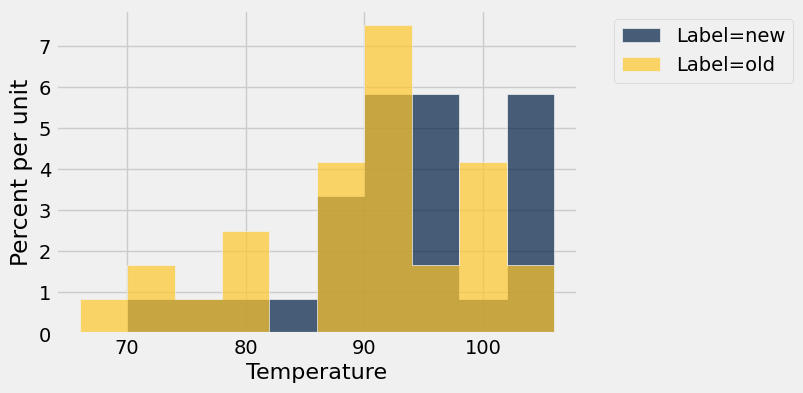

In [4]:
# Combine the sets of weather data into a new table with labels

weather_columns = np.append(weather_2024.column('Maximum Temperature'), weather_2004.column('Maximum Temperature'))
labels = np.append(30*['new'], 30*['old'])

weather_data = Table().with_columns(
    'Temperature', weather_columns,
    'Label', labels
)

#weather_data.show()

weather_data.hist('Temperature', group = 'Label')

In [5]:
# Compare the averages
weather_data.group('Label', np.average)

Label,Temperature average
new,93.3667
old,89.3


In [6]:
weather_2004.sort('Maximum Temperature').show()

Date,Maximum Temperature,Minimum Temperature
2004-09-19,66,48
2004-09-18,71,55
2004-09-20,73,46
2004-09-30,75,52
2004-09-28,78,53
2004-09-21,79,46
2004-09-29,79,52
2004-09-13,86,54
2004-09-14,86,54
2004-09-22,86,47


## Part 2: The permutation test ##

In [7]:
def difference_of_means(data_table, column):
    """Takes: name of table and column to group by
    Returns: The difference of means between the groups."""

    means = data_table.group(column, np.average).column(1)
    return means.item(0) - means.item(1)

In [8]:
difference_of_means(weather_data, 'Label')

4.066666666666663

In [9]:
# Now let's make a way to shuffle the labels. We do this by drawing
# without replacement from the column of all labels:

shuffled_labels = weather_data.sample(with_replacement = False).column(1)
original_and_shuffled = weather_data.with_column(
    'Shuffled Label', shuffled_labels)

original_and_shuffled

Temperature,Label,Shuffled Label
97,new,new
94,new,old
98,new,old
103,new,new
104,new,old
105,new,new
105,new,new
105,new,old
106,new,old
91,new,old


In [10]:
# Now let's just look at the data with shuffled labels only and
# compute the temperature deviation:

shuffled_only = original_and_shuffled.select('Temperature', 'Shuffled Label')
shuffled_only.group('Shuffled Label', np.average).show()

difference_of_means(shuffled_only, 'Shuffled Label')

Shuffled Label,Temperature average
new,91.8667
old,90.8


1.0666666666666629

In [11]:
# Now we're ready to implement the permutation test!

differences = make_array()
repetitions = 20000

for i in np.arange(repetitions):
    shuffled_labels = weather_data.sample(with_replacement = False).column(1)
    shuffled_data = weather_data.with_column(
        'Shuffled Label', shuffled_labels).drop('Label')

    new_difference = difference_of_means(shuffled_data, 'Shuffled Label')
    differences = np.append(differences, new_difference)

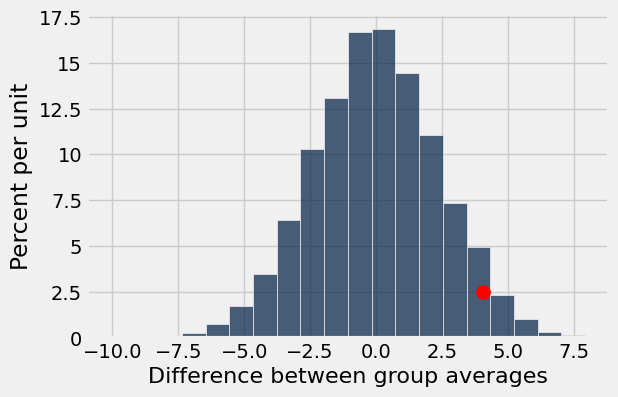

In [12]:
# Now let's make a histogram. This represents the distribution 
# UNDER THE NULL HYPOTHESIS that the samples come from the 
# same underlying distribution.

Table().with_column('Difference between group averages', differences).hist(bins=20)
observed_difference = difference_of_means(weather_data, 'Label')
plots.scatter(observed_difference, .025, c='r', s=100)

## Part 3: Computing the p-Value and computing percentiles ##

In [13]:
# We need to count how many outcomes were more extreme

p_value = sum(differences > observed_difference) / repetitions
print('Reported p-value for the difference: ' + str(p_value))

Reported p-value for the difference: 0.0432


In [15]:
# Find the 25th percentile of the distribution:
print('25th percentile: ' + str(percentile(25, differences)))

# Find the 50th percentile of the distribution:
print('50th percentile: ' + str(percentile(50, differences)))

# Find the 75th percentile
print('75th percentile: ' + str(percentile(75, differences)))

# Find the 95th percentile
print('95th percentile: ' + str(percentile(95, differences)))

# Find the 99th percentile
print('99th percentile: ' + str(percentile(99, differences)))

25th percentile: -1.6
50th percentile: 0.0
75th percentile: 1.6
95th percentile: 3.93333333333
99th percentile: 5.4
